# Load files

In [ ]:
from google.colab import files
uploaded = files.upload()

# Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neural_network import BernoulliRBM

# utils.py (only some methods)

In [4]:
def load_idxfile(filename):

    """
    Load idx file format. For more information : http://yann.lecun.com/exdb/mnist/
    """
    import struct

    with open(filename,'rb') as _file:
        if ord(_file.read(1)) != 0 or ord(_file.read(1)) != 0 :
           raise Exception('Invalid idx file: unexpected magic number!')
        dtype,ndim = ord(_file.read(1)),ord(_file.read(1))
        shape = [struct.unpack(">I", _file.read(4))[0] for _ in range(ndim)]
        data = np.fromfile(_file, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape(shape)
    return data

def read_mnist(dim=[28,28],n_train=60000,n_test=1000):

    """
    Read mnist train and test data. Images are normalized to be in range [0,1]. Labels are one-hot coded.
    """

    train_imgs = load_idxfile("train-images-idx3-ubyte")
    train_imgs = train_imgs / 255.
    train_imgs = train_imgs.reshape(-1,dim[0]*dim[1])

    train_lbls = load_idxfile("train-labels-idx1-ubyte")
    train_lbls_1hot = np.zeros((len(train_lbls),10),dtype=np.float32)
    train_lbls_1hot[range(len(train_lbls)),train_lbls] = 1.

    test_imgs = load_idxfile("t10k-images-idx3-ubyte")
    test_imgs = test_imgs / 255.
    test_imgs = test_imgs.reshape(-1,dim[0]*dim[1])

    test_lbls = load_idxfile("t10k-labels-idx1-ubyte")
    test_lbls_1hot = np.zeros((len(test_lbls),10),dtype=np.float32)
    test_lbls_1hot[range(len(test_lbls)),test_lbls] = 1.

    return train_imgs[:n_train],train_lbls_1hot[:n_train],test_imgs[:n_test],test_lbls_1hot[:n_test]

def viz_rf(weights,it,grid, directory=""):

    """
    Visualize receptive fields and save
    """
    fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1],grid[0]))#,constrained_layout=True)
    plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)
    imax = abs(weights).max()
    for x in range(grid[0]):
        for y in range(grid[1]):
            axs[x,y].set_xticks([]);
            axs[x,y].set_yticks([]);
            axs[x,y].imshow(weights[:,:,y+grid[1]*x], cmap="bwr", vmin=-imax, vmax=imax, interpolation=None)
    if not os.path.exists(directory):
      os.mkdir(directory)
    plt.savefig(os.path.join(directory,"rf.iter%06d.png"%it))
    plt.close('all')

# RMB

In [7]:
image_size = [28,28]
train_imgs,train_lbls,test_imgs,test_lbls = read_mnist(dim=image_size, n_train=60000, n_test=10000)

ndim_hidden = 500
learning_rate = 0.01
batch_size = 20
n_iterations = 20

rbm = BernoulliRBM(n_components=ndim_hidden, learning_rate=learning_rate, batch_size=batch_size, n_iter=n_iterations, verbose=1)

rbm.fit(train_imgs)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -103.22, time = 43.54s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -88.32, time = 50.77s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -82.17, time = 52.21s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -75.53, time = 51.44s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -73.74, time = 50.68s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -71.42, time = 48.58s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -71.49, time = 50.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -69.10, time = 49.62s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -67.40, time = 49.46s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -67.75, time = 49.84s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -65.60, time = 48.70s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -65.95, time = 49.44s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -65.16, time = 49.26s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -65.31, time = 49.45s
[BernoulliRBM]

BernoulliRBM(batch_size=20, learning_rate=0.01, n_components=500, n_iter=20,
             verbose=1)

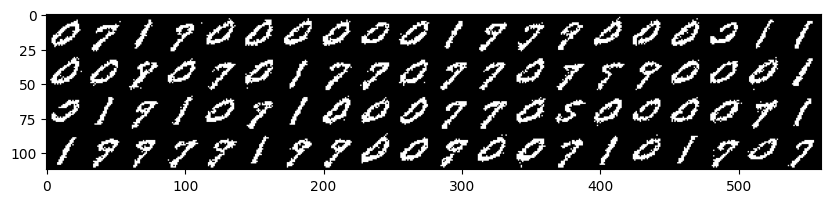

In [12]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

xx = train_imgs[:80].copy()
for _ in range(1000):
    for n in range(80):
        xx[n] = rbm.gibbs(xx[n])

import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx), cmap='gray')


In [18]:
"""
Using MNIST, compare classification performance of:
1) logistic regression by itself,
2) logistic regression on outputs of an RBM, and
3) logistic regression on outputs of a stacks of RBMs / a DBN.
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


def norm(arr):
    arr = arr.astype(np.float)
    arr -= arr.min()
    arr /= arr.max()
    return arr

train_imgs,train_lbls,test_imgs,test_lbls = read_mnist(dim=image_size, n_train=60000, n_test=10000)

X_train, X_val,  Y_train, Y_val  = train_test_split(train_imgs, train_lbls, test_size=50000, random_state=0)

# --------------------------------------------------------------------------------
# set hyperparameters

learning_rate = 0.02 # from Erhan et el. (2010): median value in grid-search
total_units   =  500 # from Erhan et el. (2010): optimal for MNIST / only slightly worse than 1200 units when using InfiniteMNIST
total_epochs  =   5 # from Erhan et el. (2010): optimal for MNIST
batch_size    =  128 # seems like a representative sample; backprop literature often uses 256 or 512 samples

C = 100. # optimum for benchmark model according to sklearn docs: https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

# TODO optimize using grid search, etc

# --------------------------------------------------------------------------------
# construct models

# RBM
rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)

# "output layer"
logistic = LogisticRegression(C=C, solver='lbfgs', multi_class='multinomial', n_features_in=10, max_iter=200, verbose=1)


model = Pipeline(steps=[('rbm1', clone(rbm)), ('rbm2', clone(rbm)), ('logistic', clone(logistic))])  # RBM stack / DBN

# --------------------------------------------------------------------------------
# train and evaluate models

model.fit(X_train, Y_train)

# evaluate using validation set
print("Model performance:\n%s\n" % (classification_report(Y_val, model.predict(X_val))))

# TODO: after parameter optimization, evaluate on test set

TypeError: ignored